# Comparison of half-life

This notebook profile the distribution and correlation of half-lives.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load data

In [2]:
data = dict()

# RNA-seq
d = pd.read_csv("../../4_RNAseq_ActD/reports/halflife_of_k562_genes.tsv", sep="\t")
d = d[(d["GeneType"] == "protein_coding") & (d["Canonical"])]
d = d[~d["GeneID"].duplicated()]
d = d[(d["FPKM.0h-1"] >= 1) & (d["FPKM.0h-2"] >= 1) & (d["R2.Score"] >= 0.8)]
d.index = d["GeneID"]
print("Number of genes with confident half-life in ActD RNA-seq: %d" % len(d))
data["RNAseq.K562"] = d

Number of genes with confident half-life in ActD RNA-seq: 7721


In [3]:
# NASC-seq
params = [
    ["NASCseq.GSE128273.K562", "../../2_NASCseq/reports/halflife_GSE128273_K562_50uM_3h.tsv"],
    ["NASCseq.K562", "../../2_NASCseq/reports/halflife_NASCseq_K562_50uM_3h.tsv"]
]
for name, path in params:
    print("-" * 80)
    print("Name:", name)
    print("Path:", path)
    d = pd.read_csv(path, sep="\t")
    d.index = d["GeneID"]
    d = d[(d["GeneType"] == "protein_coding") & (d["Canonical"]) & (d["FPKM"] >= 1) & (d["Count"] >= 100)]
    d = d[~d["GeneID"].duplicated()]
    d["T"] = d["T"].fillna(0)
    print("Number of genes with confident half-life in NASC-seq (%s): %d" % (name, len(d)))
    data[name] = d

--------------------------------------------------------------------------------
Name: NASCseq.GSE128273.K562
Path: ../../2_NASCseq/reports/halflife_GSE128273_K562_50uM_3h.tsv
Number of genes with confident half-life in NASC-seq (NASCseq.GSE128273.K562): 9453
--------------------------------------------------------------------------------
Name: NASCseq.K562
Path: ../../2_NASCseq/reports/halflife_NASCseq_K562_50uM_3h.tsv
Number of genes with confident half-life in NASC-seq (NASCseq.K562): 8156


In [4]:
# FLAIR-seq (K562)
paths = [
    ["FLAIRseq.K562.1TC", "../../1_FLAIRseq/reports/halflife_of_K562_50uM_3h.1TC.tsv"],
    ["FLAIRseq.K562.2TC", "../../1_FLAIRseq/reports/halflife_of_K562_50uM_3h.2TC.tsv"],
    ["FLAIRseq.mESC.1TC", "../../1_FLAIRseq/reports/halflife_of_mESC_400uM_3h.1TC.tsv"],
    ["FLAIRseq.mESC.2TC", "../../1_FLAIRseq/reports/halflife_of_mESC_400uM_3h.2TC.tsv"]
]
for name, path in paths:
    print("-" * 80)
    print("Name:", name)
    print("Path:", path)
    d = pd.read_csv(path, sep="\t", index_col=0)
    d = d[(d["GeneType"] == "protein_coding") & (d["Total"] >= 10)]
    print("Number of genes in FLAIR-seq: %d" % len(d))
    data[name] = d

--------------------------------------------------------------------------------
Name: FLAIRseq.K562.1TC
Path: ../../1_FLAIRseq/reports/halflife_of_K562_50uM_3h.1TC.tsv
Number of genes in FLAIR-seq: 6216
--------------------------------------------------------------------------------
Name: FLAIRseq.K562.2TC
Path: ../../1_FLAIRseq/reports/halflife_of_K562_50uM_3h.2TC.tsv
Number of genes in FLAIR-seq: 6216
--------------------------------------------------------------------------------
Name: FLAIRseq.mESC.1TC
Path: ../../1_FLAIRseq/reports/halflife_of_mESC_400uM_3h.1TC.tsv
Number of genes in FLAIR-seq: 6912
--------------------------------------------------------------------------------
Name: FLAIRseq.mESC.2TC
Path: ../../1_FLAIRseq/reports/halflife_of_mESC_400uM_3h.2TC.tsv
Number of genes in FLAIR-seq: 6912


In [5]:
# scNT-seq
# Qiu, Q., et al. (2020). "Massively parallel and time-resolved RNA sequencing in single cells with scNT-seq." Nat Methods 17(10): 991-1001.

anno_g = pd.read_csv("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.genes.tsv", sep="\t")
anno_g = anno_g[~anno_g["GeneName"].duplicated()]
anno_g.index = anno_g["GeneName"]
paths = [
    ["scNTseq.K562", "../../others/1_scNTseq/results/halflife/GSM4512694_K562-4SU-TFEA.tsv"],
    ["scNTseq.K562.N9", "../../others/1_scNTseq/results/halflife/GSM4512697_K562-4SU-TFEA-N9.tsv"]
]
for name, path in paths:
    d = pd.read_csv(path, sep="\t", index_col=0)
    d = d[~d.index.duplicated()]
    d = d.merge(anno_g, left_index=True, right_index=True, how="left")    
    d.index = d["GeneID"]
    d = d[d["Total"] >= 100]
    d = d[d["GeneType"] == "protein_coding"]
    data[name] = d

In [6]:
anno_g = pd.read_csv("/home/chenzonggui/species/mus_musculus/GRCm38.p6/gencode.vM25.genes.tsv", sep="\t")
anno_g = anno_g[~anno_g["GeneName"].duplicated()]
anno_g.index = anno_g["GeneName"]
paths = [
    ["scNTseq.pulse_chase.mESC.batch1", "../../others/1_scNTseq/results/halflife/Pulse_chase_mESC_batch1.tsv"],
    ["scNTseq.pulse_chase.mESC.batch2", "../../others/1_scNTseq/results/halflife/Pulse_chase_mESC_batch2.tsv"]
]
for name, path in paths:
    d = pd.read_csv(path, sep="\t", index_col=0)
    d = d[~d.index.duplicated()]
    d = d.merge(anno_g, left_index=True, right_index=True, how="inner")
    d.index = d["GeneID"]
    d = d[~d["T"].isna()]
    d = d[d["T"] > 0]
    data[name] = d

In [7]:
d = pd.read_excel("../../others/1_scNTseq/data/41592_2020_935_MOESM3_ESM.xlsx", sheet_name="Supplementary Table 4", header=2, index_col=0)
d = d.merge(anno_g, left_index=True, right_index=True, how="inner")
d.index = d["GeneID"]
d["T"] = d["Pluripotent_hf_hour"]
data["scNTseq.pulse_chase.mESC.Pluripotent"] = d.copy()
d["T"] = d["Intermediate_hf_hour"]
data["scNTseq.pulse_chase.mESC.Intermediate"] = d.copy()
d["T"] = d["2C_hf_hour"]
data["scNTseq.pulse_chase.mESC.2C"] = d.copy()

In [8]:
# SLAM-seq (mESC)
# Herzog, V. A., et al. (2017). "Thiol-linked alkylation of RNA to assess expression dynamics." Nat Methods 14(12): 1198-1204.
d = pd.read_excel("data/41592_2017_BFnmeth4435_MOESM4_ESM.xls", index_col=3)
d = d[~d.index.duplicated()]
d = d.merge(anno_g, left_index=True, right_index=True, how="inner")
d.index = d["GeneID"]
d["T"] = d["Half-life (h)"]
data["SLAMseq.mESC"] = d

In [9]:
for name, d in data.items():
    print(len(d), name, sep="\t")

7721	RNAseq.K562
9453	NASCseq.GSE128273.K562
8156	NASCseq.K562
6216	FLAIRseq.K562.1TC
6216	FLAIRseq.K562.2TC
6912	FLAIRseq.mESC.1TC
6912	FLAIRseq.mESC.2TC
4347	scNTseq.K562
7707	scNTseq.K562.N9
2233	scNTseq.pulse_chase.mESC.batch1
2494	scNTseq.pulse_chase.mESC.batch2
2556	scNTseq.pulse_chase.mESC.Pluripotent
2556	scNTseq.pulse_chase.mESC.Intermediate
2556	scNTseq.pulse_chase.mESC.2C
5826	SLAMseq.mESC


## 2. Half-life distribution

RNAseq.K562


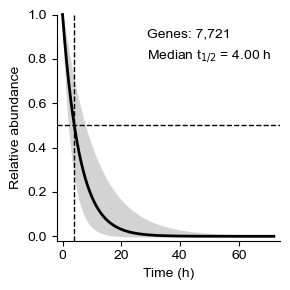

NASCseq.GSE128273.K562


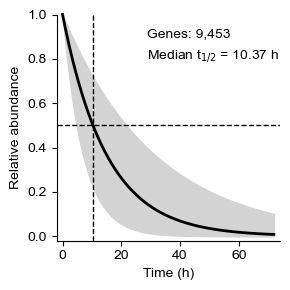

NASCseq.K562


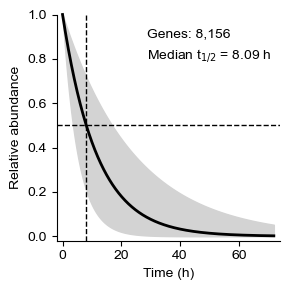

FLAIRseq.K562.1TC


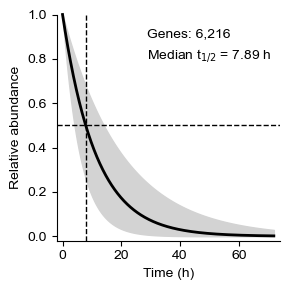

FLAIRseq.K562.2TC


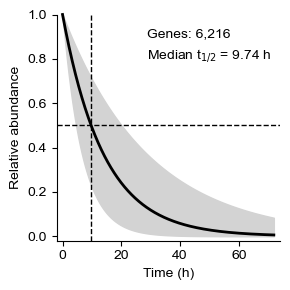

FLAIRseq.mESC.1TC


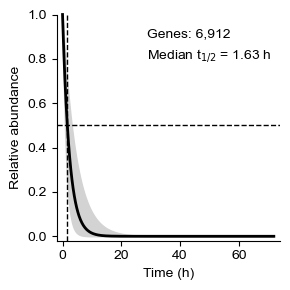

FLAIRseq.mESC.2TC


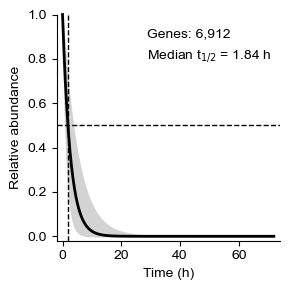

scNTseq.K562


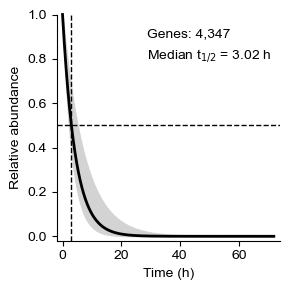

scNTseq.K562.N9


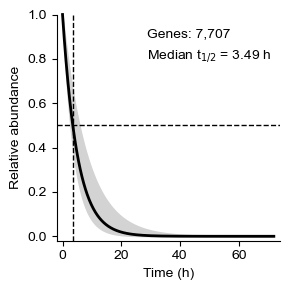

scNTseq.pulse_chase.mESC.batch1


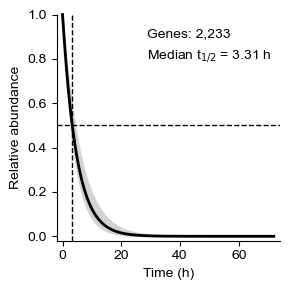

scNTseq.pulse_chase.mESC.batch2


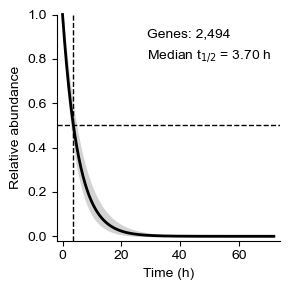

scNTseq.pulse_chase.mESC.Pluripotent


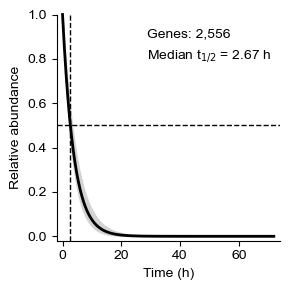

scNTseq.pulse_chase.mESC.Intermediate


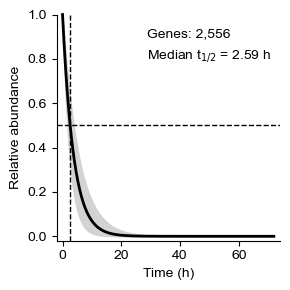

scNTseq.pulse_chase.mESC.2C


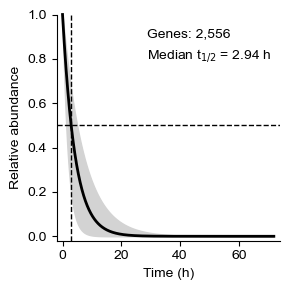

SLAMseq.mESC


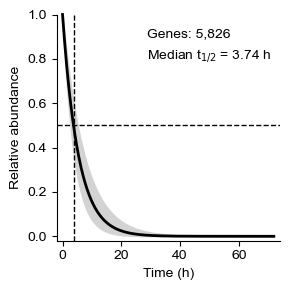

In [10]:
# Distribution of half-life

def adjust_halflife(hts, min_ht=0.5, max_ht=32):
    return [max(min_ht, min(t, max_ht)) for t in hts]
    
def plot_halflife_distribution(hts, outfile=None, xlim=72):
    hts = adjust_halflife(hts)
    xs = np.arange(0, xlim, 0.1)
    rows = []
    ht = np.median(hts)
    for T in hts:
        ys = [0.5**(x/T) for x in xs]
        rows.append(ys)
    d = pd.DataFrame(rows)
    ys = []
    ys1 = []
    ys2 = []
    for i in d.columns:
        vs = list(sorted(d[i]))
        y = np.median(vs)
        y1 = vs[int(len(vs) * 0.25)]
        y2 = vs[int(len(vs) * 0.75)]
        ys.append(y)
        ys1.append(y1)
        ys2.append(y2)
    plt.figure(figsize=(3, 3))
    plt.plot(xs, ys, color="black", lw=2, clip_on=False)
    plt.fill_between(xs, ys1, ys2, color="lightgrey", clip_on=False)
    plt.text(xlim * 0.4, 0.9, "Genes: %s" % format(len(d), ","))
    plt.text(xlim * 0.4, 0.8, "Median t$_{1/2}$ = %.2f h" % ht)
    plt.axhline(0.5, ls="--", lw=1, color="black")
    plt.axvline(ht, ls="--", lw=1, color="black")
    plt.xlim(0 - 2, xlim + 2)
    plt.ylim(-0.02, 1)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xlabel("Time (h)")
    plt.ylabel("Relative abundance")
    plt.tight_layout()
    if outfile is None:
        plt.show()
    else:
        plt.savefig(outfile)
        plt.show()
        # plt.close()
        
for name, d in data.items():
    print(name)
    outfile = "figures/global_gene_halflife.%s.pdf" % name
    plot_halflife_distribution(d["T"], outfile=outfile)

8156 6216
5914 5914


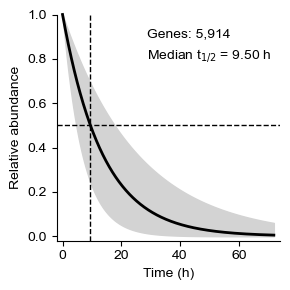

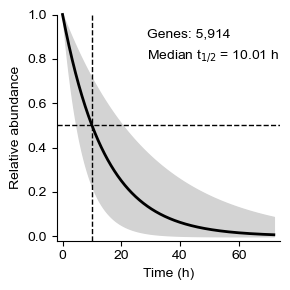

In [16]:
# 半衰期中位数不是转录组所有基因的半衰期中位数，是被检测到的基因的半衰期中位数。

d1 = data["NASCseq.K562"]
d2 = data["FLAIRseq.K562.2TC"]
print(len(d1), len(d2))
d1 = d1[d1.index.isin(d2.index)]
d2 = d2[d2.index.isin(d1.index)]
print(len(d1), len(d2))

outfile = "figures/global_gene_halflife.%s.pdf" % "NASCseq.K562.final"
plot_halflife_distribution(d1["T"], outfile=outfile)
outfile = "figures/global_gene_halflife.%s.pdf" % "FLAIRseq.K562.final"
plot_halflife_distribution(d2["T"], outfile=outfile)

## 3. Correlation of half-life (all)

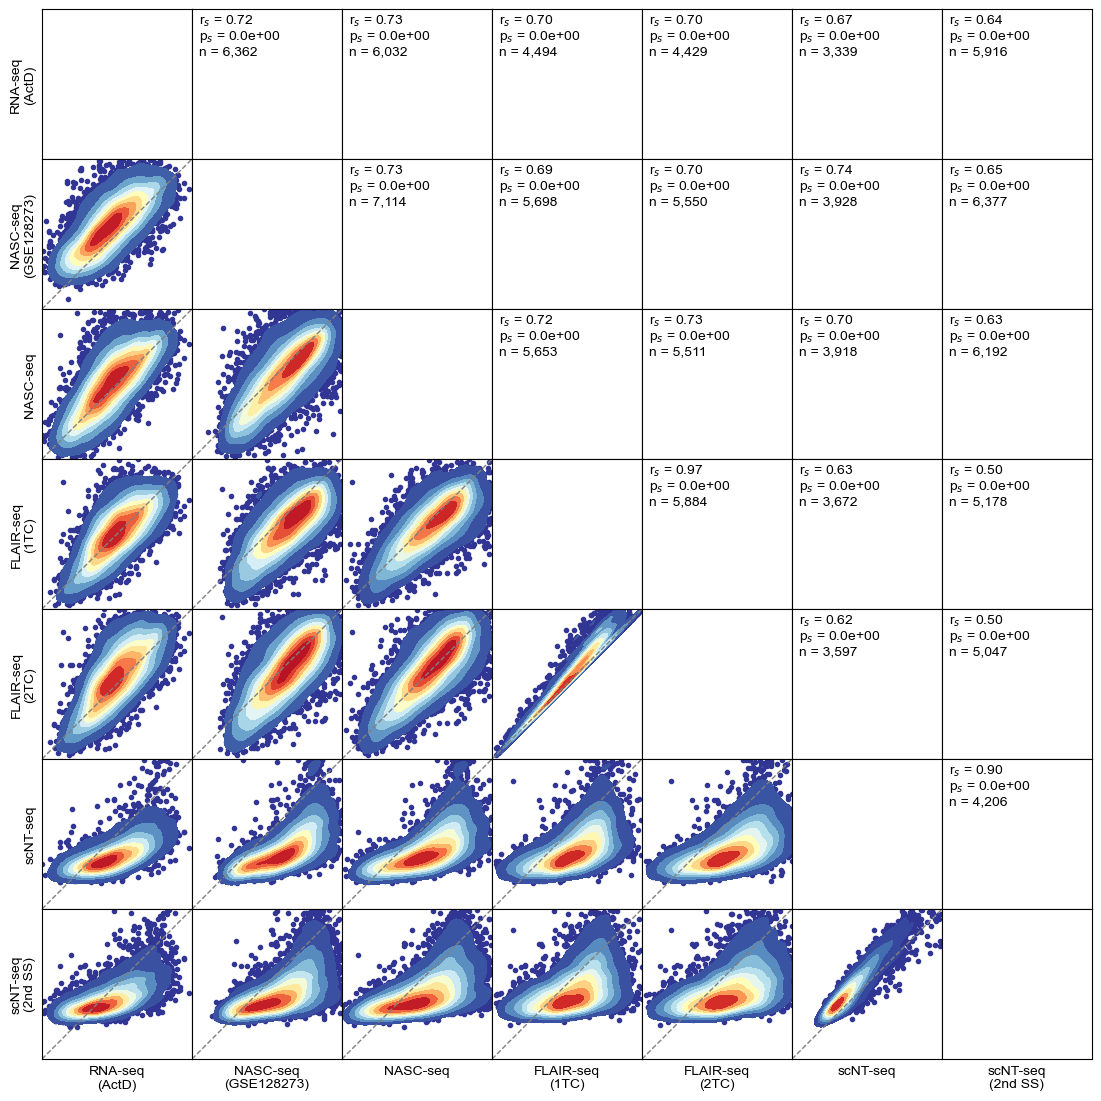

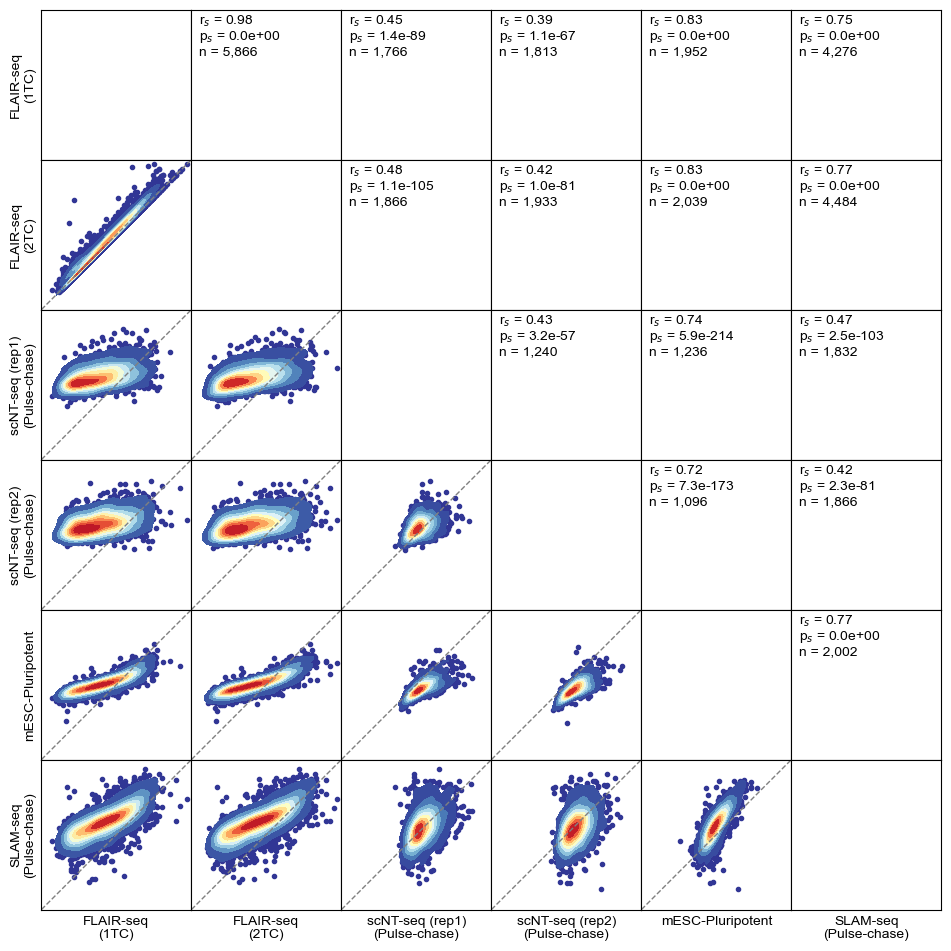

In [ ]:
def plot_correlation(names, labels, vmin, vmax, outfile):

    nrow = len(names)
    width, height = nrow * 1.5 + 0.7, nrow * 1.5 + 0.7
    fig, axs = plt.subplots(nrow, nrow, figsize=(width, height), sharex=False, sharey=False,
                            gridspec_kw=dict(wspace=0, hspace=0, left=0.5/width, right=1-0.2/width, bottom=0.5/height, top=1-0.2/height))
    for i in range(len(names)):
        for j in range(len(names)):
            ax = axs[i][j]
            plt.sca(ax)
            if j == 0:
                plt.ylabel(labels[i])
            if i == len(names) - 1:
                plt.xlabel(labels[j])
            if i != j:
                d1, d2 = data[names[j]], data[names[i]]
                s1, s2 = d1["T"], d2["T"]
                d3 = pd.concat([s1, s2], axis=1, join="inner")
                d3.columns = ["T.ref", "T.query"]
                # min_ht = 2**vmin
                # max_ht = 2**vmax
                d3 = d3[(d3.min(axis=1) > 2**vmin) & (d3.max(axis=1) < 2**vmax)]
                xs, ys = d3["T.ref"], d3["T.query"]
                # xs, ys = adjust_halflife(d3["T.ref"]), adjust_halflife(d3["T.query"])
                xs, ys = np.log2(xs), np.log2(ys)
                # print("-" * 40)
                # print("x-axis:", names[j])
                # print("y-axis:", names[i])
                # print("Spearman:", spearmanr(xs, ys))
                r_s, p_s = spearmanr(xs, ys)
                if i > j:
                    plt.scatter(xs, ys, marker=".", color=matplotlib.colormaps["RdYlBu_r"](0), zorder=1)
                    sns.kdeplot(x=list(xs), y=list(ys), fill=True, cmap='RdYlBu_r', cbar=False, alpha=1, zorder=2)
                    plt.plot([vmin, vmax], [vmin, vmax], lw=1, ls="--", color="grey")
                elif i < j:
                    plt.text(vmin + (vmax - vmin) * 0.05, vmin + (vmax - vmin) * 0.9, "r$_s$ = %.2f" % r_s)
                    plt.text(vmin + (vmax - vmin) * 0.05, vmin + (vmax - vmin) * 0.8, "p$_s$ = %.1e" % p_s)
                    plt.text(vmin + (vmax - vmin) * 0.05, vmin + (vmax - vmin) * 0.7, "n = %s" % format(len(d3), ","))
            plt.xlim(vmin, vmax)
            plt.ylim(vmin, vmax)
            if False: # i == len(names) - 1 and j == 0:
                vs1 = np.arange(vmin, vmax + 1)
                vs2 = ["%s" % 2**int(v) for v in vs1]
                plt.xticks(vs1, vs2, rotation=45)
                plt.yticks(vs1, vs2)
            else:
                plt.xticks([])
                plt.yticks([])
    plt.savefig(outfile, dpi=300)


names = ["RNAseq.K562", "NASCseq.GSE128273.K562", "NASCseq.K562", 
         "FLAIRseq.K562.1TC", "FLAIRseq.K562.2TC", 
         "scNTseq.K562", "scNTseq.K562.N9"]
labels = ["RNA-seq\n(ActD)", "NASC-seq\n(GSE128273)", "NASC-seq", 
          "FLAIR-seq\n(1TC)", "FLAIR-seq\n(2TC)", 
          "scNT-seq", "scNT-seq\n(2nd SS)"]
vmin, vmax = -1, 6
outfile = "figures/halflife_correlation.K562.pdf"
plot_correlation(names, labels, vmin, vmax, outfile)

names = ["FLAIRseq.mESC.1TC", "FLAIRseq.mESC.2TC", 
         "scNTseq.pulse_chase.mESC.batch1", "scNTseq.pulse_chase.mESC.batch2", 
         "scNTseq.pulse_chase.mESC.Pluripotent", 
         "SLAMseq.mESC"]
labels = ["FLAIR-seq\n(1TC)", "FLAIR-seq\n(2TC)",
          "scNT-seq (rep1)\n(Pulse-chase)", "scNT-seq (rep2)\n(Pulse-chase)", 
          "mESC-Pluripotent", 
          "SLAM-seq\n(Pulse-chase)"]
vmin, vmax = -2, 5
outfile = "figures/halflife_correlation.mESC.pdf"
plot_correlation(names, labels, vmin, vmax, outfile)

## 4. Correlation of half-life (pairwise)

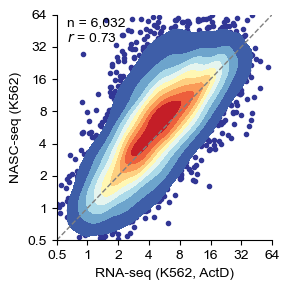

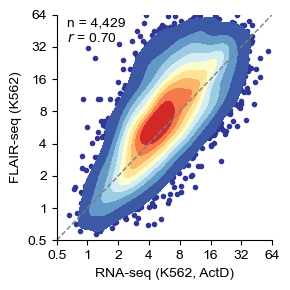

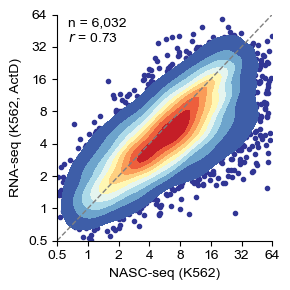

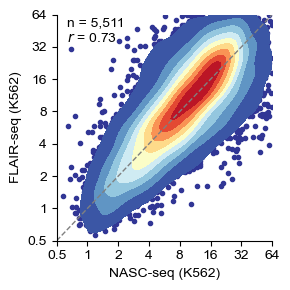

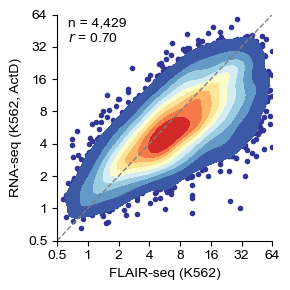

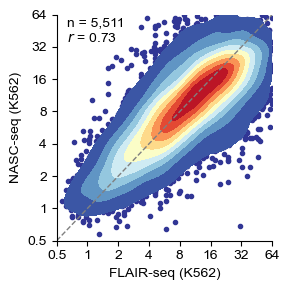

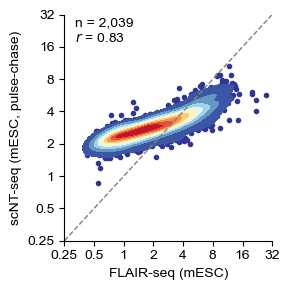

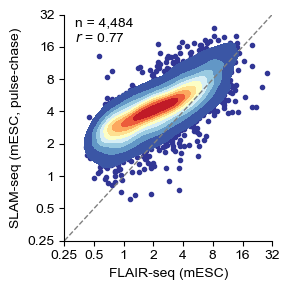

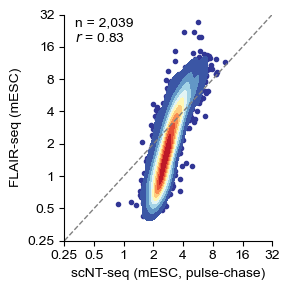

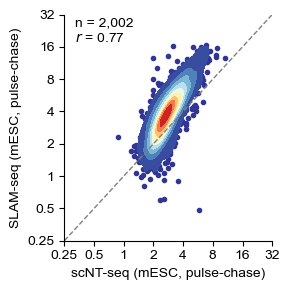

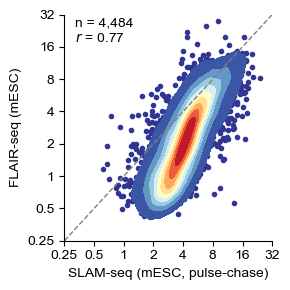

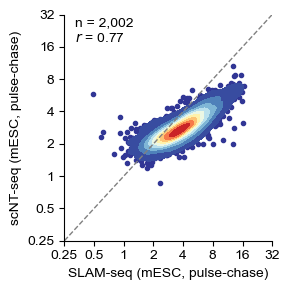

In [11]:
def plot_single_correlation(names, labels, vmin=-1, vmax=6, outfile=None):
    plt.figure(figsize=(3, 3))
    plt.ylabel(labels[1])
    plt.xlabel(labels[0])
    d1, d2 = data[names[0]], data[names[1]]
    s1, s2 = d1["T"], d2["T"]
    d3 = pd.concat([s1, s2], axis=1, join="inner")
    d3.columns = ["T.ref", "T.query"]
    d3 = d3[(d3.min(axis=1) > 2**vmin) & (d3.max(axis=1) < 2**vmax)]
    xs, ys = d3["T.ref"], d3["T.query"]
    xs, ys = np.log2(xs), np.log2(ys)
    r_s, p_s = spearmanr(xs, ys)
    plt.scatter(xs, ys, marker=".", color=matplotlib.colormaps["RdYlBu_r"](0), zorder=1)
    sns.kdeplot(x=list(xs), y=list(ys), fill=True, cmap='RdYlBu_r', cbar=False, alpha=1, zorder=2)
    plt.plot([vmin, vmax], [vmin, vmax], lw=1, ls="--", color="grey")
    plt.text(vmin + (vmax - vmin) * 0.05, vmin + (vmax - vmin) * 0.88, "$\it{r}$ = %.2f" % r_s)
    #plt.text(vmin + (vmax - vmin) * 0.05, vmin + (vmax - vmin) * 0.8, "p$_s$ = %.1e" % p_s)
    plt.text(vmin + (vmax - vmin) * 0.05, vmin + (vmax - vmin) * 0.95, "n = %s" % format(len(d3), ","))
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    vs1 = np.arange(vmin, vmax + 1)
    vs2 = ["%s" % 2**int(v) for v in vs1]
    plt.xticks(vs1, vs2)
    plt.yticks(vs1, vs2)
    for loc in ["top", "right"]:
        plt.gca().spines[loc].set_visible(False)
    plt.tight_layout()
    if outfile:
        plt.savefig(outfile)
    plt.show()
    plt.close()

names = ["RNAseq.K562", "NASCseq.K562", "FLAIRseq.K562.2TC"]
labels = ["RNA-seq (K562, ActD)", "NASC-seq (K562)", "FLAIR-seq (K562)"]
vmin, vmax = -1, 6
for i in range(len(names)):
    for j in range(len(names)):
        if i != j:
            names1 = [names[i], names[j]]
            labels1 = [labels[i], labels[j]]
            outfile1 = "figures/halflife_correlation.%s_vs_%s.pdf" % (names1[0], names1[1])
            plot_single_correlation(names1, labels1, vmin, vmax, outfile1)

names = ["FLAIRseq.mESC.2TC", "scNTseq.pulse_chase.mESC.Pluripotent", "SLAMseq.mESC"]
labels = ["FLAIR-seq (mESC)", "scNT-seq (mESC, pulse-chase)", "SLAM-seq (mESC, pulse-chase)"]
vmin, vmax = -2, 5
for i in range(len(names)):
    for j in range(len(names)):
        if i != j:
            names1 = [names[i], names[j]]
            labels1 = [labels[i], labels[j]]
            outfile1 = "figures/halflife_correlation.%s_vs_%s.pdf" % (names1[0], names1[1])
            plot_single_correlation(names1, labels1, vmin, vmax, outfile1)